# A few tips to get started with homework 3

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray as xr

In [2]:
ndbc_files = sorted(glob.glob('data/NDBC/460*.nc'))
ndbc_list = []
for f in ndbc_files:
    ndbc_list.append(xr.open_dataset(f).squeeze(drop=True))
ds = xr.merge(ndbc_list)

In [4]:
ds

<xarray.Dataset>
Dimensions:                  (time: 22904)
Coordinates:
  * time                     (time) datetime64[ns] 2016-12-31T23:50:00 ... 20...
Data variables:
    wind_dir                 (time) float64 279.0 291.0 293.0 ... 170.0 232.0
    wind_spd                 (time) float32 6.4 6.3 5.3 3.9 ... 12.0 12.1 11.4
    gust                     (time) float32 7.3 7.3 6.6 4.9 ... 15.0 14.6 13.7
    wave_height              (time) float32 2.41 2.13 2.39 ... 4.64 4.43 4.88
    dominant_wpd             (time) timedelta64[ns] 00:00:12.899999619 ... 00...
    average_wpd              (time) timedelta64[ns] 00:00:06.500000 ... 00:00...
    mean_wave_dir            (time) float64 nan nan nan ... 274.0 261.0 232.0
    air_pressure             (time) float32 1041.3 1041.1 1041.2 ... 978.1 977.9
    air_temperature          (time) float32 5.6 5.5 5.5 5.5 ... 6.5 6.7 6.5 4.7
    sea_surface_temperature  (time) float32 6.4 6.4 6.4 6.4 ... 6.1 6.1 6.1 6.1
    dewpt_temperature        (time) float32 nan nan nan nan ... nan nan nan nan
    visibility               (time) float32 nan nan nan nan ... nan nan nan nan
    water_level              (time) float32 nan nan nan nan ... nan nan nan nan

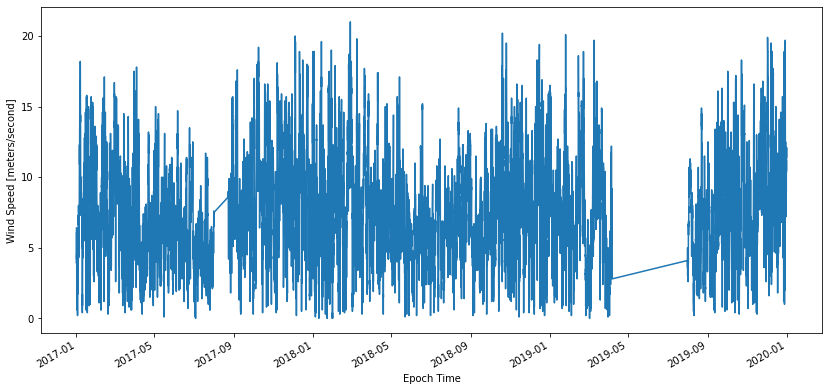

In [5]:
# let's plot the wind speed
plt.figure(figsize=(14, 6))
ds.wind_spd.plot()

In [6]:
# Now, let's group the wind speed by month and compute the mean
wind_mean = ds.wind_spd.groupby('time.month').mean()

# Similarly, we can compute the standard deviation
wind_std = ds.wind_spd.groupby('time.month').std()

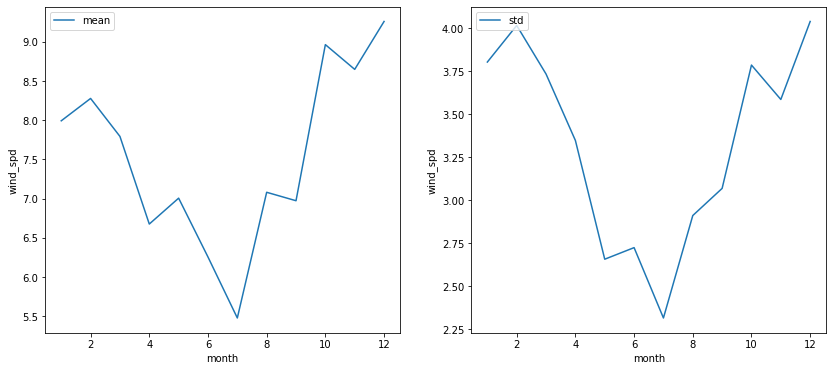

In [7]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
wind_mean.plot(label='mean')
plt.legend(loc=2)
plt.subplot(122)
wind_std.plot(label='std')
plt.legend(loc=2)

To compute the standard error we need to know how many degree of fredom we have. The problem set says two independent samples per day. So let's first resample our data on that frequency (0.5 days). After doing that we have two measurements per day (T00:00 and T12:00). We're not really gonna use this data (the wind speed values), but we wanna count how many points we have.

In [8]:
twice_day = ds.wind_spd.resample(time="0.5D").mean()
twice_day.time

<xarray.DataArray 'time' (time: 2191)>
array(['2016-12-31T12:00:00.000000000', '2017-01-01T00:00:00.000000000',
       '2017-01-01T12:00:00.000000000', ..., '2019-12-30T12:00:00.000000000',
       '2019-12-31T00:00:00.000000000', '2019-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-12-31T12:00:00 ... 2019-12-31T12:00:00

Now, we won't to group this twice per day measurements into months and count how many measurements per month we get on each month

In [9]:
wind_neff = twice_day.groupby('time.month').count()
wind_neff

<xarray.DataArray 'wind_spd' (month: 12)>
array([186, 168, 186, 133, 124, 120, 124, 143, 180, 186, 180, 186])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

So this will be our effective degrees of freedom for the wind speed for each month.

In [10]:
wind_stde = wind_std/(wind_neff)**.5

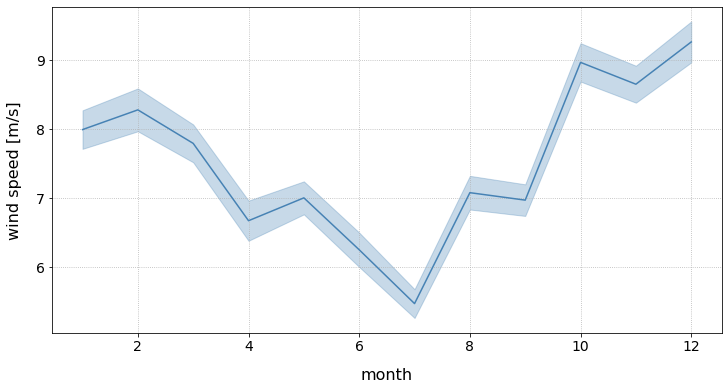

In [19]:
plt.figure(figsize=(12,6))
plt.plot(wind_mean.month, wind_mean, color='steelblue')
plt.fill_between(wind_mean.month, wind_mean-wind_stde,  wind_mean+wind_stde, color='steelblue', alpha=0.3)
plt.ylabel('wind speed [m/s]', fontsize=16, labelpad=14)
plt.yticks(fontsize=14)
plt.xlabel('month', fontsize=16, labelpad=14)
plt.xticks(fontsize=14)
plt.grid(ls='dotted')